In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from plot import plot_learning_perturbation, plot_learning
import matplotlib.pyplot as plt

#%matplotlib qt
#%matplotlib widget
%matplotlib inline


fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 20
save_fig = '/Users/mahdiyar/Diedrichsenlab Dropbox/Mahdiyar Shahbazi/Conferences/NCM2024_Mahdiyar/figures'

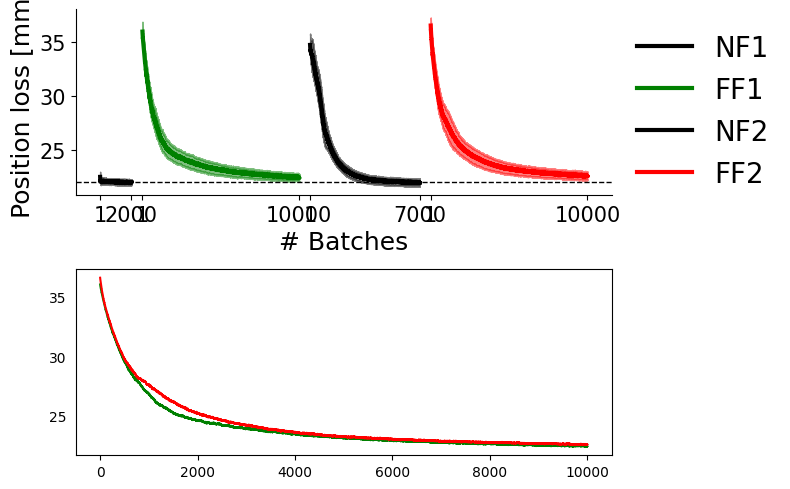

In [113]:
#phase = {'NF2':[0]}
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[-8]}

folder_name = 'Sim_all_128_inv'
loss_type = 'position'
ignore = []

fig, ax = plot_learning(folder_name,num_model=20,w=1,phases=phase,loss_type=loss_type,figsize=(8,5),ignore=ignore,show_saving=True,gap=700)


ax[0].set_xlabel('# Batches', fontsize = fontsize_label)
ax[0].set_ylabel('Position loss [mm]', fontsize = fontsize_label)
ax[0].legend(title = '',frameon = False, bbox_to_anchor= (1,1), fontsize=fontsize_legend)
ax[0].xaxis.set_tick_params(labelsize=fontsize_tick)
ax[0].yaxis.set_tick_params(labelsize=fontsize_tick)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
plt.tick_params(left = False) 

plt.tight_layout()
plt.show()

#fig.savefig(os.path.join(save_fig,'bahav_saving.pdf'),dpi=300,bbox_inches='tight')

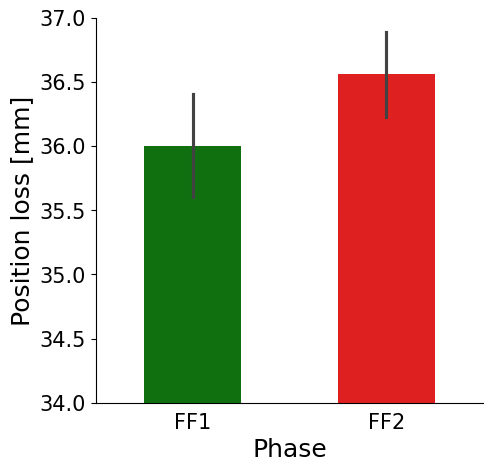

In [114]:
# plot saving
import numpy as np
from plot import window_average
import json
from get_utils import get_dir



phases = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[-8]}
num_model = 20
loss_type = 'position'

w = 1

all_phase = list(phases.keys())

# load behavior and start fitting
loss = {phase: [] for phase in phases.keys()}
for i,phase in enumerate(phases.keys()):
    for m in range(num_model):
        model_name = "model{:02d}".format(m)
        _,_,log=get_dir(folder_name, model_name, phase, phases[phase][0])
        log = json.load(open(log,'r'))
        loss[phase].append(log[loss_type])

    # Calculate window averages for all models
    loss[phase] = [window_average(np.array(l), w) for l in loss[phase]]

saving_behav = np.array(loss['FF1'])[:,0] - np.array(loss['FF2'])[:,0]



import pandas as pd

nf1_values = np.array(loss['NF1'])[:,-1]
ff1_values = np.array(loss['FF1'])[:,0]
nf2_values = np.array(loss['NF2'])[:,-1]
ff2_values = np.array(loss['FF2'])[:,0]

# Combine 'FF1' and 'FF2' into a single column, and do the same for their values
lose_type = ['NF1'] * len(nf1_values) + ['FF1'] * len(ff1_values) + ['NF2'] * len(nf2_values) + ['FF2'] * len(ff2_values)
values = np.concatenate([nf1_values, ff1_values, nf2_values, ff2_values])

# Create the DataFrame
T = pd.DataFrame({
    'lose type': lose_type,
    'value': values
})

import seaborn as sb

fig,ax = plt.subplots(1,1,figsize=(5,5))

T = T[~T['lose type'].isin(['NF1', 'NF2'])]

palette_colors = {'FF1': 'g', 'FF2': 'r', 'NF1': 'k', 'NF2': 'k'}

sb.barplot(x='lose type',y='value',data=T,hue='lose type',width=0.5,ax=ax,palette=palette_colors)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom = False) 
ax.set_xlabel('Phase', fontsize = fontsize_label)
ax.set_ylabel('Position loss [mm]', fontsize = fontsize_label)

#ax.legend(loc='lower left', fontsize=fontsize_legend,frameon=False)

#ax.set_ylim([34.5,36.5])
ax.set_ylim([34,37]) # for 128
#ax.set_ylim([37,40]) # for 64
#ax.set_ylim([41,46]) # for 32
#ax.set_ylim([44,50]) # for 16

fig.savefig(os.path.join(save_fig,'savingFF2neg_batch0.pdf'),dpi=300,bbox_inches='tight')

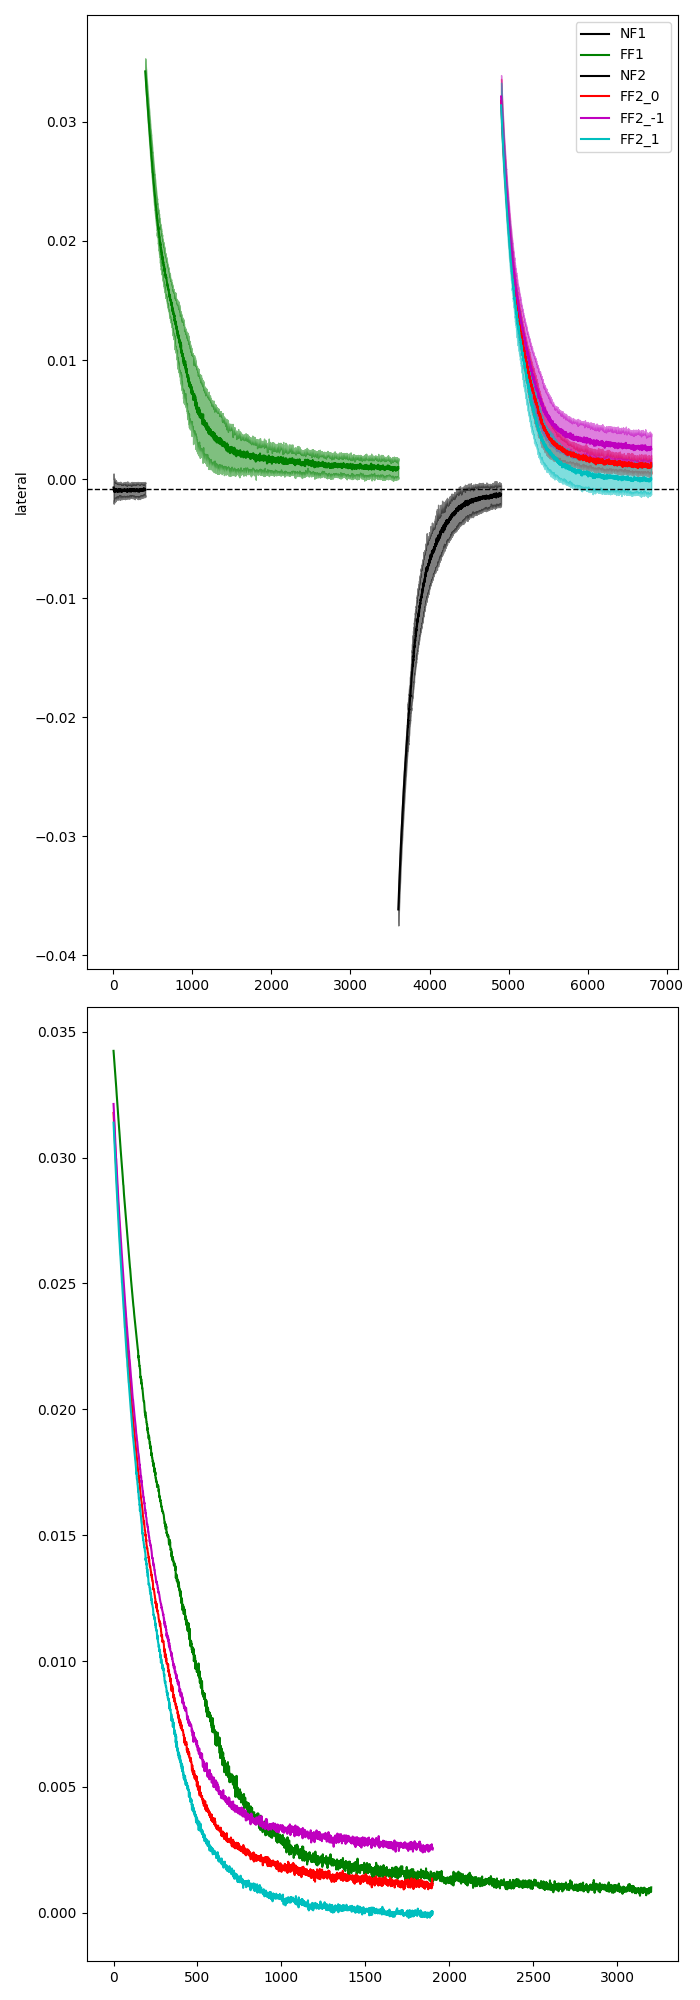

In [ ]:
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
folder_name = 'Sim_simple2'

#%matplotlib widget

fig, ax = plot_learning_perturbation(folder_name,num_model=20,w=1,phases=phase,loss_type='lateral',figsize=(7,20),ignore=[],show_saving=True)
plt.tight_layout()
plt.show()